In [1]:
import scipy.io, math, os
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from utils import *
from nltk.corpus import cmudict
from numpy import linalg as LA
import seaborn as sns
import pylab
import scipy.stats as stats
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from scipy.spatial import distance
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import Levenshtein
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation
from metaphone import doublemetaphone

In [2]:
subjects = ['F1', 'F5', 'M1', 'M3']
subj_index = 0

# set of words that is present for each subject 
words = []
with open('usablewords.txt', 'r') as file:
    lines = file.read().splitlines()
    for word in lines:
        words.append(word)

# for determining the number of syllables 
d = cmudict.dict()

In [3]:
# TODO: put this in utils file 
def get_srate(file_number):
    directory = 'data/Data/{}/mat'.format(subjects[subj_index])
    
    files = sorted(os.listdir(directory))
    try:
        files.remove('.DS_Store')
    except:
        pass
    
    file = files[file_number]
    
    f = os.path.join(directory, file)
    mat = scipy.io.loadmat(f)['usctimit_ema_{}_{:03}_{:03}'.format(subjects[subj_index].lower(), file_number*5 + 1, file_number*5 + 5)]
    
    #returns the srate which is awkwardly stored here
    return mat[0][1][1][0][0]

In [4]:
directory = 'data/Data/{}/mat'.format(subjects[subj_index])
counter = 1
UL_df, LL_df, JW_df, TD_df, TB_df, TT_df = [], [], [], [], [], []

for filename in sorted(os.listdir(directory)):
    if filename.endswith('.mat'):
        f = os.path.join(directory, filename)
        mat = scipy.io.loadmat(f)
        # takes the data that is stored at the key that precedes the data for each .mat file
        data = mat['usctimit_ema_{}_{:03}_{:03}'.format(subjects[subj_index].lower(), counter, counter + 4)]
        counter += 5

        # make dataframes of the six positions
        UL_df.append(pd.DataFrame.from_dict(data[0][1][2]))
        LL_df.append(pd.DataFrame.from_dict(data[0][2][2]))
        JW_df.append(pd.DataFrame.from_dict(data[0][3][2]))
        TD_df.append(pd.DataFrame.from_dict(data[0][4][2]))
        TB_df.append(pd.DataFrame.from_dict(data[0][5][2]))
        TT_df.append(pd.DataFrame.from_dict(data[0][6][2]))
        
dataframes = [UL_df, LL_df, JW_df, TB_df, TD_df, TT_df]

In [5]:
includeZ = False

frames = {}
sensors = ['ULx', 'ULy', 'LLx', 'LLy', 
           'JWx', 'JWy', 'TDx', 'TDy',
           'TBx', 'TBy', 'TTx', 'TTy',]
if includeZ:
    sensors = ['ULx', 'ULy', 'ULz', 'LLx', 'LLy', 'LLz', 
               'JWx', 'JWy', 'JWz', 'TDx', 'TDy', 'TDz',
               'TBx', 'TBy', 'TBz', 'TTx', 'TTy', 'TTz']

with open('timestamps{}.txt'.format(subjects[subj_index]), 'r') as file:
    timestamps = file.read().splitlines()
    word_number = 0
    for line in timestamps:
        split_line = line.split(',')
        
        if split_line[1] in words:
            words.remove(split_line[1])
            sent_number = int(split_line[-1])
        
            # find start and end by multiplying the timestamps with the sampling rate
            starting_point = math.floor(float(split_line[2]) * get_srate(int(split_line[0])))
            end_point = math.ceil(float(split_line[3]) * get_srate(int(split_line[0])))
        
            # make new dataframe for the current word
            df = pd.DataFrame()
        
            for sensor in sensors:
                # position, dimension, file_number, starting_point, end_point, data
                array = get_pos_list(sensor[:2], sensor[-1], int(split_line[0]), starting_point, end_point, dataframes)
                df[sensor] = pd.Series(array)
                df.word = split_line[1]
                # TODO: get rid of UserWarning 
                df.sent = int(split_line[-1])
                df.syl = nsyl(split_line[1], d)
                frames[word_number] = df
            
            word_number += 1
        else:
            continue 

/var/folders/jz/414l_qjs6s1bndtz3ppcy8cc0000gn/T/ipykernel_18480/1451125292.py:36: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.syl = nsyl(split_line[1], d)


In [6]:
# test if the current subject has any words with missing data
missing = []

for frame in frames:
    if frames[frame].isnull().values.any():
        missing.append(frame)
            
if len(missing) > 0:
    raise Exception("Words found with missing data")

In [7]:
do_normalize = True

syl1_words, syl2_words, syl3_words = {}, {}, {}
syl4_words, syl5_words, syl6_words = {}, {}, {}

syl_frames = [syl1_words, syl2_words, 
              syl3_words, syl4_words, 
              syl5_words, syl6_words]

# fit scaler on a global level to prevent local standardization 
scaler = StandardScaler()
scaler.fit(pd.concat(frames))

for i in range(1, len(syl_frames) + 1):
    for count, frame in enumerate(frames):
        # for some reason some words store the number of syllables in an array, hence:
        if (isinstance(frames[frame].syl, list) and frames[frame].syl[0] == i) or\
            (not isinstance(frames[frame].syl, list) and frames[frame].syl == i):
            # standardize the data to have a mean of 0 and approx. a SD of 1
            if do_normalize:
                data = scaler.transform(frames[frame])
                df = pd.DataFrame(data, columns=sensors)
                syl_frames[i - 1][count] = df
                
                # set meta-data, at this point we only need the word and the sentence it came from
                syl_frames[i - 1][count].word = frames[frame].word
                syl_frames[i - 1][count].sent = frames[frame].sent
            else:
                syl_frames[i - 1][count] = frames[frame]

In [8]:
# padding 
# just an observation: running this code twice returns an exception, will look into it later 
for i, frame in enumerate(syl_frames):
    # target length is the the word with the most samples in that syllable category
    target_length = longest_frame(frame)
    for word in frame.keys():
        current_length = frame[word].shape[0]
        pad_length1 = int((target_length - current_length) / 2)
        if np.mod((target_length - current_length),2) == 1:
            pad_length2 = pad_length1 + 1
        else:
            pad_length2 = pad_length1

        frame[word] = pd.DataFrame(np.pad(frame[word].values, 
                                   ((pad_length1,pad_length2), (0,0)), 'mean'),
                                   columns=sensors).transpose()

In [9]:
labels_syl1, labels_syl2, labels_syl3 = [], [], []
labels_syl4, labels_syl5, labels_syl6 = [], [], []

labels = [labels_syl1, labels_syl2, 
          labels_syl3, labels_syl4, 
          labels_syl5, labels_syl6]

for i, frame in enumerate(syl_frames):
    for word in frame:
        try:
            labels[i].append(frames[word].word)
        except:
            pass

In [95]:
difference_matrix_1, difference_matrix_2, difference_matrix_3 = [], [], []
difference_matrix_4, difference_matrix_5, difference_matrix_6 = [], [], []

difference_matrices = [difference_matrix_1, difference_matrix_2, 
                       difference_matrix_3, difference_matrix_4, 
                       difference_matrix_5, difference_matrix_6]

for i, matrix in enumerate(syl_frames):
    if i == 4:
        for row_word in matrix.values():
            row = np.array([])
            for column_word in matrix.values():
                # calculate the frob norm for each word pair and putting it into diff matrix 
                difference_matrix = row_word.subtract(column_word).to_numpy()
                frob_norm = linalg.norm(difference_matrix)

                row = np.append(row, frob_norm)

            difference_matrices[i].append(row)
    
        # turn into correlation matrix 
        diff = np.array([difference_matrices[i]])
        df = pd.DataFrame(diff[0])
        df.columns, df.index = labels[i], labels[i]
        correlations = df.corr()
        correlations_array = np.asarray(df.corr())
    
        # replace the uncondensed matrix with the condensed one
        difference_matrices[i] = correlations

In [38]:
difference_matrix_1_f5, difference_matrix_2_f5, difference_matrix_3_f5 = [], [], []
difference_matrix_4_f5, difference_matrix_5_f5, difference_matrix_6_f5 = [], [], []

difference_matrices_f5 = [difference_matrix_1_f5, difference_matrix_2_f5, 
                          difference_matrix_3_f5, difference_matrix_4_f5, 
                          difference_matrix_5_f5, difference_matrix_6_f5]

for i, matrix in enumerate(syl_frames):
    for row_word in matrix.values():
        row = np.array([])
        for column_word in matrix.values():
            # calculate the frob norm for each word pair and putting it into diff matrix 
            difference_matrix = row_word.subtract(column_word).to_numpy()
            frob_norm = linalg.norm(difference_matrix)

            row = np.append(row, frob_norm)

        difference_matrices_f5[i].append(row)
    
    # turn into correlation matrix 
    diff = np.array([difference_matrices_f5[i]])
    df = pd.DataFrame(diff[0])
    df.columns, df.index = labels[i], labels[i]
    correlations = df.corr()
    correlations_array = np.asarray(df.corr())
    
    # replace the uncondensed matrix with the condensed one
    difference_matrices_f5[i] = correlations

In [51]:
difference_matrix_1_m1, difference_matrix_2_m1, difference_matrix_3_m1 = [], [], []
difference_matrix_4_m1, difference_matrix_5_m1, difference_matrix_6_m1 = [], [], []

difference_matrices_m1 = [difference_matrix_1_m1, difference_matrix_2_m1, 
                          difference_matrix_3_m1, difference_matrix_4_m1, 
                          difference_matrix_5_m1, difference_matrix_6_m1]

for i, matrix in enumerate(syl_frames):
    
    for row_word in matrix.values():
        row = np.array([])
        for column_word in matrix.values():
            # calculate the frob norm for each word pair and putting it into diff matrix 
            difference_matrix = row_word.subtract(column_word).to_numpy()
            frob_norm = linalg.norm(difference_matrix)

            row = np.append(row, frob_norm)

        difference_matrices_m1[i].append(row)
    
    # turn into correlation matrix 
    diff = np.array([difference_matrices_m1[i]])
    df = pd.DataFrame(diff[0])
    #df.columns, df.index = labels[i], labels[i]
    correlations = df.corr()
    correlations_array = np.asarray(df.corr())
    
    # replace the uncondensed matrix with the condensed one
    difference_matrices_m1[i] = correlations

In [11]:
# TODO: change this to phoneme distance 

Levenshtein_matrix_1, Levenshtein_matrix_2, Levenshtein_matrix_3 = [], [], []
Levenshtein_matrix_4, Levenshtein_matrix_5, Levenshtein_matrix_6 = [], [], []

Levenshtein_matrices = [Levenshtein_matrix_1, Levenshtein_matrix_2, 
                        Levenshtein_matrix_3, Levenshtein_matrix_4, 
                        Levenshtein_matrix_5, Levenshtein_matrix_6]

for i, arr in enumerate(labels):
    for row_word in labels[i]:
        row = np.array([])
        for column_word in labels[i]:
            lev = Levenshtein.distance(row_word, column_word)
            row = np.append(row, lev)

        Levenshtein_matrices[i].append(row)
        
    # turn into correlation matrix 
    diff = np.array([Levenshtein_matrices[i]])
    df = pd.DataFrame(diff[0])
    df.columns, df.index = labels[i], labels[i]
    correlations = df.corr()
    correlations_array = np.asarray(df.corr())
    
    # replace the uncondensed matrix with the condensed one
    Levenshtein_matrices[i] = correlations

In [12]:
minoftwo = False

metaphone_matrix_1, metaphone_matrix_2, metaphone_matrix_3 = [], [], []
metaphone_matrix_4, metaphone_matrix_5, metaphone_matrix_6 = [], [], []

metaphone_matrices = [metaphone_matrix_1, metaphone_matrix_2, 
                      metaphone_matrix_3, metaphone_matrix_4, 
                      metaphone_matrix_5, metaphone_matrix_6]

for i, matrix in enumerate(labels):
    for row_word in labels[i]:
        row = np.array([])
        for column_word in labels[i]:
            # need to concat the words or choose either the first or second code 
            meta1 = doublemetaphone(row_word)[0] + doublemetaphone(row_word)[1]
            meta2 = doublemetaphone(column_word)[0] + doublemetaphone(column_word)[1]
            meta2inv = doublemetaphone(column_word)[1] + doublemetaphone(column_word)[0]
            
            lev1 = Levenshtein.distance(meta1, meta2)
            lev2 = Levenshtein.distance(meta1, meta2inv)
            
            if minoftwo:
                row = np.append(row, min([lev1, lev2]))
            else:
                row = np.append(row, lev1)

        metaphone_matrices[i].append(row)
    
    # turn into correlation matrix 
    diff = np.array([metaphone_matrices[i]])
    df = pd.DataFrame(diff[0])
    df.columns, df.index = labels[i], labels[i]
    correlations = df.corr()
    correlations_array = np.asarray(df.corr())
    
    # replace the uncondensed matrix with the condensed one
    metaphone_matrices[i] = correlations

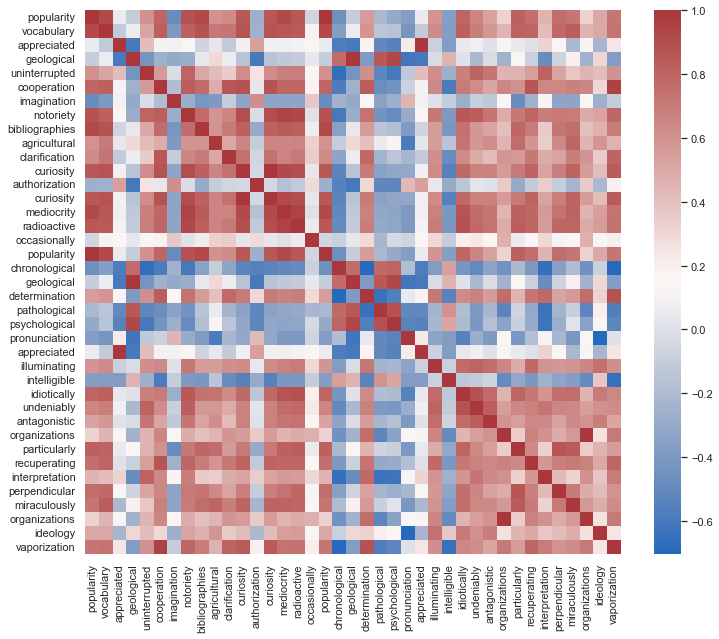

In [30]:
sns.set(rc = {'figure.figsize':(12,10)})
ax = sns.heatmap(metaphone_matrices[4], cmap = 'vlag')

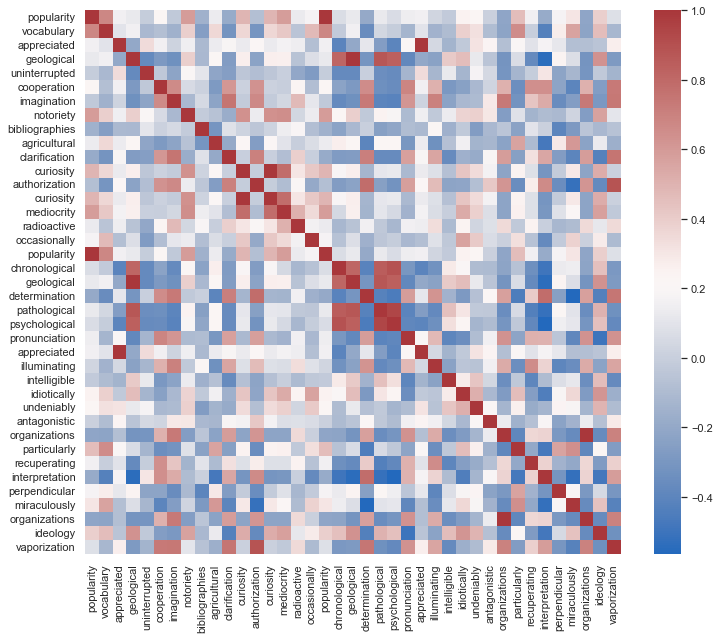

In [31]:
sns.set(rc = {'figure.figsize':(12,10)})
ax = sns.heatmap(Levenshtein_matrices[4], cmap = 'vlag')

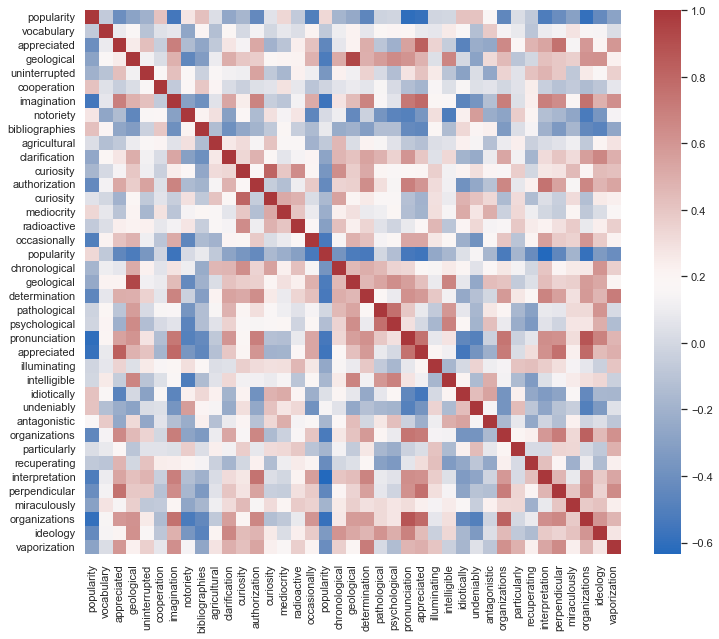

In [27]:
sns.set(rc = {'figure.figsize':(12,10)})
ax = sns.heatmap(difference_matrices[4], cmap = 'vlag')

In [14]:
scores = pd.DataFrame({'number of syl': []}, {'pearson r': []}, {'p': []})
scores = []

for i in range(len(Levenshtein_matrices)):
    score = [i + 1,
             stats.spearmanr(upper(difference_matrices[i]), upper(Levenshtein_matrices[i]))[0],
             stats.spearmanr(upper(difference_matrices[i]), upper(Levenshtein_matrices[i]))[1]]
    scores.append(score)

df = pd.DataFrame(scores)
df.columns = ['number of syllables', 'pearson r', 'p'] 
df.reset_index(drop=True, inplace=True)

df

,number of syllables,pearson r,p
0,1,0.001189,9.408169e-02
1,2,-0.002208,1.883779e-01
2,3,0.044165,6.563065e-28
3,4,0.080392,1.521097e-11
4,5,0.159641,1.263574e-05
5,6,0.382143,1.598236e-01


In [96]:
# TODO: turn this into general code instead of syl5 code

row_linkage = hierarchy.linkage(
    distance.pdist(correlations_array), method='average')

X = row_linkage

# make clusters with hierarchical clustering 
# TODO: find the best value for t
syl5_hierarchical_clusters = {}
hierarchical_clusters = hierarchy.fcluster(row_linkage, t=1)
zipped = tuple(zip(hierarchical_clusters, labels))
for pair in zipped:
    if pair[0] in syl5_hierarchical_clusters:
        syl5_hierarchical_clusters[pair[0]].append(pair[1])
    else:
        syl5_hierarchical_clusters[pair[0]] = [pair[1]]

# make clusters with kmeans clustering 
syl5_kmeans_clusters = {}
clustering = AgglomerativeClustering(n_clusters=2).fit(X)
kmeans_clusters = clustering.labels_
zipped = tuple(zip(kmeans_clusters, labels))
for pair in zipped:
    if pair[0] in syl5_kmeans_clusters:
        syl5_kmeans_clusters[pair[0]].append(pair[1])
    else:
        syl5_kmeans_clusters[pair[0]] = [pair[1]]

# make clusters with affinity propagation
syl5_AP_clusters = {}
clustering = AffinityPropagation(random_state=0, damping=0.5).fit(X)
AP_clusters = clustering.labels_
centers = clustering.cluster_centers_
zipped = tuple(zip(AP_clusters, labels))
for pair in zipped:
    if pair[0] in syl5_AP_clusters:
        syl5_AP_clusters[pair[0]].append(pair[1])
    else:
        syl5_AP_clusters[pair[0]] = [pair[1]]

In [29]:
from sklearn_extra.cluster import KMedoids

In [97]:
row_linkage = hierarchy.linkage(
    distance.pdist(correlations_array), method='average')

In [98]:
kmediods_clusters = KMedoids(n_clusters=10, random_state=0).fit(X)
ind = kmediods_clusters.medoid_indices_

In [99]:
for i in ind:
    print(labels_syl5[i])

determination
antagonistic
curiosity
popularity
uninterrupted
curiosity
illuminating
notoriety
bibliographies
idiotically


In [100]:
labels_syl6

['encyclopedias',
 'reorganization',
 'inferiority',
 'coeducational',
 'archeological',
 'audiovisual']

In [90]:
ind

array([106, 309,  35, 242, 172,  60,  82, 225, 140, 228])

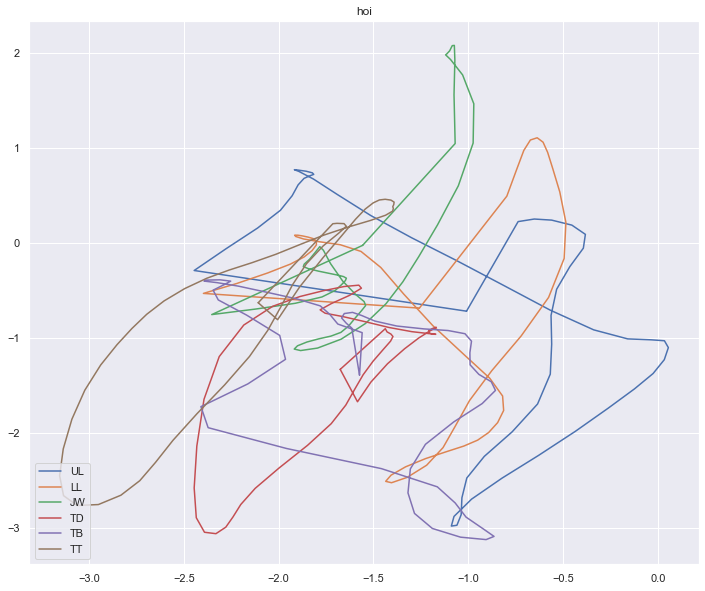

In [47]:
def make_traj_plot(df_word_sensors, word):
    "df_word_sensors: df per word Nx12, N is time, 12 sensors"
    fig, ax = plt.subplots(1, 1)
    x = df_word_sensors
    for i_sen, s in enumerate(['UL', 'LL', 'JW', 'TD', 'TB', 'TT']):
        ax.plot(x[s + 'x'], x[s + 'y'], label=s)

    plt.legend(['UL', 'LL', 'JW', 'TD', 'TB', 'TT'], loc='lower left')
    ax.set_title(word)

make_traj_plot(syl_frames[2][180].T, 'hoi')